# Meeting (and Not Meeting) the Assumptions of Linear Regression

Previously, in checkpoint 19.02, you saw that OLS pins down the coefficients of the linear regression model by minimizing the sum of the model's squared error terms.  However, in order for estimated coefficients to be valid and test statistics associated with them to be reliable, some assumptions about the data and the model should be met.  These assumptions are known as __Gauss Markov Assumptions__ or __Gauss Markov Conditions__.  

Before interpreting the estimated coefficients of a linear regression model, it's always a good idea to check whether the Gauss Markov assumptions hold.  Otherwise, you need to try to fix your model.  Sometimes this means applying a technique to solve for a specific problem.  But usually, you need to change the model by including additional variables or excluding problematic ones.  Once you have corrected the model, you can then re-estimate it using OLS and check whether or not the Gauss Markov conditions are met.  This is an iterative process.

\* Note on the number of __Gauss Markov Conditions__: Don't get surprised if you see in some places that the number of Gauss Markov Conditions is four, five, or six.  This is because some of the conditions can be derived from the others.  For the sake of clarity, these notes will introduce Gauss Markov Conditions in six bullets.
- linearity of models in their coefficients
- the error term should be zero on average
- homoscedasity
- low multicollinearity
- error terms should be uncorrelated with one another
- features shouldn't be correlated with the errors
- normality of the errors

## Return to the Medical Cost Model 

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import statsmodels.formula.api as smf

from sklearn import linear_model 
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL

import warnings

warnings.filterwarnings(action="ignore")

kagle = dict(
    drivername = 'postgresql',
    username = 'dsbc_student',
    password = '7*.8G9QH21',
    host = '142.93.121.174',
    port = '5432',
    database = 'medicalcosts',
)

In [2]:
# Load the data from the "medicalcosts" database and display some observations

engine=create_engine(URL(**kagle), echo=True)

insurance_df = pd.read_sql_query("SELECT * FROM medicalcosts", con=engine)

engine.dispose()

2019-12-28 14:39:59,475 INFO sqlalchemy.engine.base.Engine select version()
2019-12-28 14:39:59,477 INFO sqlalchemy.engine.base.Engine {}
2019-12-28 14:39:59,592 INFO sqlalchemy.engine.base.Engine select current_schema()
2019-12-28 14:39:59,593 INFO sqlalchemy.engine.base.Engine {}
2019-12-28 14:39:59,697 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-12-28 14:39:59,700 INFO sqlalchemy.engine.base.Engine {}
2019-12-28 14:39:59,754 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-12-28 14:39:59,756 INFO sqlalchemy.engine.base.Engine {}
2019-12-28 14:39:59,812 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2019-12-28 14:39:59,812 INFO sqlalchemy.engine.base.Engine {}
2019-12-28 14:39:59,919 INFO sqlalchemy.engine.base.Engine SELECT * FROM medicalcosts
2019-12-28 14:39:59,921 INFO sqlalchemy.engine.base.Engine {}


In [4]:
insurance_df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.90
1,18,male,33.770,1,no,southeast,1725.55
2,28,male,33.000,3,no,southeast,4449.46
3,33,male,22.705,0,no,northwest,21984.50
4,32,male,28.880,0,no,northwest,3866.86
5,31,female,25.740,0,no,southeast,3756.62
6,46,female,33.440,1,no,southeast,8240.59
7,37,female,27.740,3,no,northwest,7281.51
8,37,male,29.830,2,no,northeast,6406.41
9,60,female,25.840,0,no,northwest,28923.10


In [5]:
insurance_df["is_male"] = pd.get_dummies(insurance_df.sex, drop_first=True)
insurance_df["is_smoker"] = pd.get_dummies(insurance_df.smoker, drop_first=True)

In [6]:
# Y is the target variable 
Y = insurance_df["charges"]
# X is the feature set which includes is_male and is_smoker variables
X = insurance_df[["is_male","is_smoker"]]

# Create a LinearRegression model object from scikit-learn's linear-model module
lrm = linear_model.LinearRegression()

# Fit method estimates the coefficients using OLS
lrm.fit(X,Y)

# Inspect the results
print(f"\nCoefficients: \n{lrm.coef_}")
print(f"\nIntercept: \n{lrm.intercept_}")


Cofficients: 
[  -65.37868556 23622.13598049]

Intercept: 
8466.035592512448


## Assumption One: Linearity of the Model in its Coefficients

The first assumption that must be met is that the target variable should be a linear function of the models __coefficients__.  People often confuse this condition by incorrectly thinking that the relationship between target and features must be linear in the sense of being a straight line.  But this need not be the case.  The relationship could be quadratic or higher order.  A model like $ (eq.1) $ is completely valid: $ y = \beta_0 + \beta_1x_1 + \beta_2x_2^2 + \epsilon \qquad(eq.1) $

_A model is linear when each term is either a constant or the product of a parameter and a predictor.  A linear equation is constructed by adding the results for each term.  This constrains the the equation to one basic form:_ $ Response = constant + parameter*predictor + \dots + parameter*predictor $

_"Linear in parameters" in Linear Regression, means no parameter appears as an exponent, or multiplied or divided by another parameter._

***Problems***: _non-linearity, wrong determinants, wrong estimates; a relationship that is actually there that can not be detected with a linear model._

As mentioned earlier, linear regression modeling is quite flexible in capturing non-linear relationships between target and features.  For example, in $ (eq.1) $, the relationship between the $ y $ and $ x $ is indeed quadratic.  Below, illustrates how linear regression correctly estimates the intercept and the coefficients of the following model using synthetic data: $ y = 1 + 2x_1 + 3x_1^2 \qquad(eq.2) $


Coefficients: 
[2. 3.]

Intercept: 
0.999999999650754


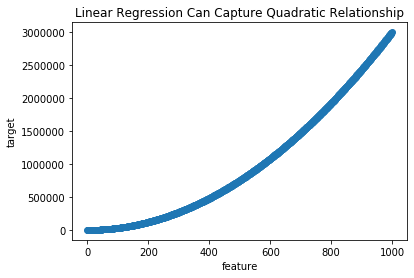

In [8]:
df = pd.DataFrame()

# data from 0 to 999
df["X"] = np.arange(0,1000,1)
# take the wquare of X
df["X_sq"] = df["X"]**2

# This is eq.1: Y = 1 + 2*X + 3*X^2
df["Y"] = 1 + 2*df["X"] + 3*df["X_sq"]

# fit a linear regressions where target is Y and features are X and X^2
lrm_example = linear_model.LinearRegression()
lrm_example.fit(df[["X","X_sq"]],df["Y"])

# predictions of the linear regression
predictions = lrm_example.predict(df[["X","X_sq"]])

# print the estimated coefficients
print(f"\nCoefficients: \n{lrm_example.coef_}")
print(f"\nIntercept: \n{lrm_example.intercept_}")

# plot the estimated Y & X, you can see that the relationship is quadratic
plt.scatter(df["X"], predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title("Linear Regression Can Capture Quadratic Relationship")
plt.show();

As you can see, the linear regression model correctly estimated the true coefficients and captured the quadratic relationship between the target and the feature.  

In contrast, a model like $ (eq.2) $ is an invalid one as it violated the linearity assumption: $ y = \beta_0 + \beta_1x_1 + \beta_1^2x_1 + \epsilon \qquad(eq.2) $ 

The relationship between the target $ y $ and the coefficient $ \beta_1 $ is said to be non-linear because if you hold all independent variables $ x $ and other coefficients constant, the graph of $ y $ for changing $ \beta_1 $  is not a straight line.

In principal, this assumption is not related to estimation but how you specify the model.  So, as long as you use models that take into account this linearity assumption as demonstrated you need not worry about this assumption.

## Assumption Two: The Error Term Should be Zero on Average

This second assumption states that the expected value of the error term should be zero.  In mathematical terms: $ \mathbb{E} (\epsilon) = 0 $

***Problem***_: intercept is biased_

The $ \mathbb{E} $ symbol indicated the expectation operator.  This can be read as: "The average of the error terms should be equal to zero"*.  The error term accounts for the variation in the target variable that is not explained by the features.  So, ideally, the error term shouldn't explain anything in the variation of the target variable but instead should be determined randomly.  If the expected value of the error is different than zero, the model would become biased!  For example, if  $ \mathbb{E}(\epsilon) = -1 $, then it means that the model systematically overpredicts the target variable.

This assumption is not held if you forget to include the constant term in your model, hence the emphasis on always including a constant in your model.  As long as you include a constant in a model, you shouldn't be worried about this assumption as the constant will force the error terms to be zero on average.

In the Medical Costs model, you can see this happening:

In [9]:
predictions = lrm.predict(X)
errors = Y - predictions

print(f"Mean of the errors in the medical costs model is {np.mean(errors)}")

Mean of the errors in the medical costs model is -7.477161225337976e-14


Since a constant was included in the model, the average of the model's error is effectively zero.

## Assumption Three: Homoscedasticity

The third assumption is the requirement of __homoscedasticity__.  A model is homoscedastic when the distribution of its error terms (known as "scedasticity") is consistent for all predicted values.  In other words, the error variance shouldn't systematically change across observations.  When this assumption is not met, you are dealing with __heteroscedasticity__.

Put differently ***homoscedasticity***_: The conditional variance of the error term is constant in all $ x $ and over time.  Homoscedasticity implies that the model uncertainty is identical across observations._

***Problem***_: __Heteroscedasticity__ - variance of error term is different across observations = model uncertainty varies from observation to observation - often a problem in cross-sectional data, omitted variables bias._

For example, if your error terms aren't consistently distributed and you have more variance in the error for large outcome values than for small ones, then the confidence interval for large predicted values will be too small because it will be based on the average error variance.  This leads to overconfidence in the accuracy of the model's predictions.

Check out whether the medical costs model suffers from heteroscedasticity by visualizing it:

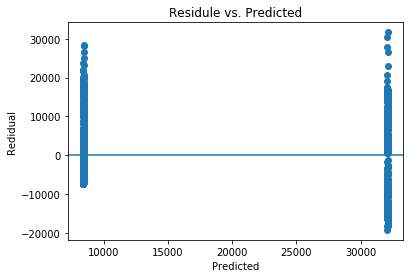

In [10]:
plt.scatter(predictions, errors)
plt.xlabel("Predicted")
plt.ylabel("Redidual")
plt.axhline(y=0)
plt.title("Residule vs. Predicted")
plt.show();

It seems that error variance is higher for the higher values of the target variable.  This implies that the error terms are not homoscedastic.  However, deriving conclusions from visuals is only an informal way of figuring out the problem.  Thankfully, there are several formal statistical tests that you can use to determine whether there is heteroscedasticity in the error terms.

Here, you can demonstrate two of them: __Bartlett__ and __Levene__ tests.  The null hypothesis for both tests is that the errors are homoscedastic.  Both tests can be imported from scipy's stats module.

In [12]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print(f"Bartlett test statistic value is {bart_stats[0]:3g} and p-value is {bart_stats[1]:3g}")
print(f"Levene test statistic value is {lev_stats[0]:3g} and p-value is {lev_stats[1]:3g}")

Bartlett test statistic value is 78.9785 and p-value is 6.27894e-19
Levene test statistic value is 6.87294 and p-value is 0.00880067


The p-values of both tests are lower than 0.05.  So, the test results reject the null hypothesis which means the errors are heteroscedastic.  

There may be several causes of heteroscedasticity.  Examples include outliers in the data and omitted variables that are important in explaining the variance of the target variable.  Dealing with heteroscedasticity include transforming the dependent variable (see [Box Cox transformation](https://www.statisticshowto.datasciencecentral.com/box-cox-transformation/) and [log transformation](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4120293/)) and adding features that target the poorly-estimated areas.

If you are working on a dataset that has a limited number of features and your model suffers from heteroscedasticity because of omitted variables, then fixing this problem is not easy.  However, keep in mind that even though the model suffers from the heteroscedasticity, the estimated coefficients are still valid (more formally, they are consistent but that is not a discussion for this module.  In interested, you can read about it here: [Wikipedia article](https://en.wikipedia.org/wiki/Consistent_estimator))  The only problem is with the reliability of some statistical tests like t-test.  Heteroscedasticity may make some estimated coefficients seem to be statistically insignificant.  This will be discussed later.

## Assumption Four: Low Multicollinearity

Individual features should be only weakly correlated with one another, and ideally completely uncorrelated. When features are correlated, they may both explain the same pattern of variance in the outcome.  The model will attempt to find a solution, potentially by attributing half the explanatory power to one feature and half to the other.  This isn’t a problem if our only goal is prediction, because then all that matters is that the variance gets explained. However, if we want to know which features matter most when predicting an outcome, multicollinearity can cause us to underestimate the relationship between features and outcomes.

***Problem***_: spatial correlation (panel and cross-sectional data), serial correlation / autocorrelation (panel and time-series data)_

If there is correlation of 1 or -1 between a variable and another or several variables, this is called **perfect multicollinearity**. It is easy to understand perfect collinearity between two variables. But how can one variable be correlated with several variables? This happens when one variable is a linear combination of the others. 

**A remark on dummy variables:** Caution is needed when working with dummy variables because of this linear combination issue. If we create some dummy variables from a categorical variable, then we need to exclude one of them from the model. This is because any one of those dummy variables can be represented as 1 minus the sum of the others. Hence a perfect multicollinearity occurs.

To detect multicollinearity, we can simply look at the correlation matrix of the features. Multicollinearity can be fixed by PCA or by discarding some of the correlated features.

## Assumption Five: Error Terms Should be Uncorrelated with One Another

Error terms should be uncorrelated with one another.  In other words, the error term for one observation shouldn't predict the error term for another.  This type of serial correlation may happen if you omit a relevant variable from the model.  So, including that variable into the model can solve for this issue.

***Problems***_: omitted variable bias, endogeneity and simultaneity_

To identify whether the error terms are correlated with each other or not, you can graph them.  In the grapy you need to observer randomness.

Check out the Medical Costs model's errors:

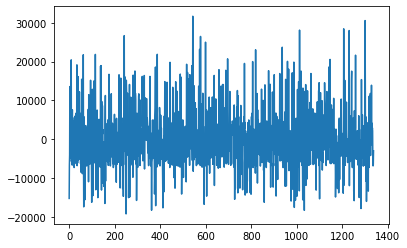

In [13]:
plt.plot(errors)
plt.show();

It seems that the error terms of the model are uncorrelated with each other.

Another way to look at correlations between errors is to use the __autocorrelation function__.  This function computes the correlation of a variable with itself, the order of the errors are the orders of the observations.  You can use the `acf()` from `statsmodel` as follows: 

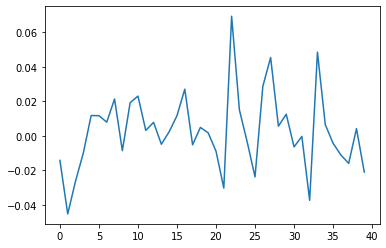

In [14]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show();

The autocorrelation between the errors of the Medical Costs model is indeed very low (ranging between -0.06 and 0.05).

## Assumption Six: Features Shouldn't be Correlated with the Errors

Last but definitely, not least, and arguably the most important assumption: explanatory variables and errors should be independent.  If this assumption doesn't hold, then the model's predictions will be unreliable as the estimates of the coefficients would be biased.  This assumption is known as the __exogeneity__.

***Problems***_: measurement errors, multicolinearity_

Violations of the exogeneity assumption may have several sources.  Common causes are omitted variables and simultaneous causation between independent variables and the target.  If the problem stems from simultaneous causation then you need to apply some advanced techniques to solve for the issue but this is beyond the bootcamp's scope.

## <font color=red>A Very Important Remark on the Normality of the Errors</font>

So far you've covered six assumptions for OLS regression.  Another important thing to consider is the normality of the error terms.  Although it is not an assumption of OLS, it is still can impact your results.  Specifically, normality of errors is not required to apply OLS to a linear regression model, but in order to measure the statistical significance of the estimated coefficients, error terms must be normally distributed.  You will circle back to a discussion of t- and F-test, which rest upon the normality of the errors in the next checkpoint, 19.04

More often than not, non-normally distributed errors stem from omitted variables.  Including the omitted relevant features to the model may help fix the issue.  Sometimes, transforming the dependent variable also helps.

There are various ways to check for normality of error terms.  An informal way of doing this is by visualizing the errors in a QQ plot or to look at the histogram:

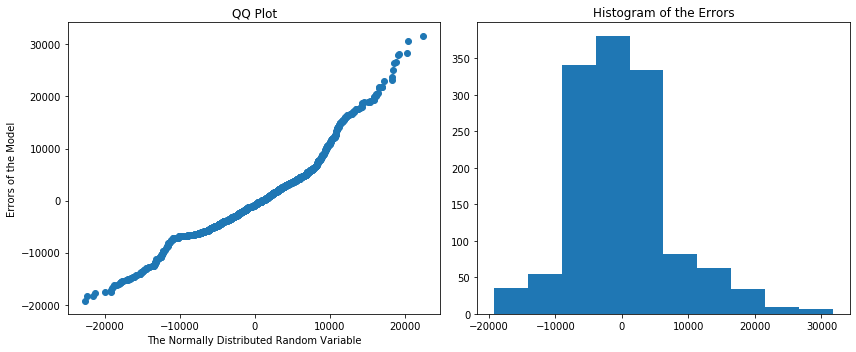

In [15]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums),  np.sort(errors)) # sort the arrays
plt.xlabel("The Normally Distributed Random Variable")
plt.ylabel("Errors of the Model")
plt.title("QQ Plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.title("Histogram of the Errors")

plt.tight_layout()
plt.show();

As  can be seen in the charts above, the errors are normally distributed exactly, But the QQ plot and the histogram imply that the distribution is not very fare away from normal.

While visualization give a first impression about normality, the best way to learn about this is to apply formal statistical tests.  To this end, you will use two of them from scipy's stats module: __Jarque Bera__ and __normal__ tests.  The null hypothesis of both tests is that the errors are normally distributed.

Run the tests and find out whether the error terms are normally distributed or not:

In [17]:
from scipy.stats import jarque_bera 
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print(f"Jarque-Bera test statistics is {jb_stats[0]} and p-value is {jb_stats[1]}")
print(f"Normality test statistice is {norm_stats[0]} and p-value is {norm_stats[1]}")

Jarque-Bera test statistics is 211.89696216982128 and p-value is 0.0
Normality test statistice is 135.8419839939868 and p-value is 3.178981278604034e-30


The p-values of both tests indicate that the errors are not normally distributed.

# Assignments

To close out this checkpoint, you'll do two assignments. Both require you to create Jupyter notebooks. Please submit links to your notebooks below

### 1. Predicting temperature

In this exercise, you'll work with historical temperature data from the Szeged, Hungary area. The dataset you'll use is a Postgres database version of [this dataset from Kaggle](https://www.kaggle.com/budincsevity/szeged-weather/home). To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

* First, load the dataset from the **weatherinszeged** table from Thinkful's database.
* Build a regression model where the target variable is *temperature*. As explanatory variables, use *humidity*, *windspeed*, *windbearing*, and *pressure*. Estimate the model using OLS.
* Now, check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

Here are the credentials you can use to connect to the database:

```
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'
```

As in earlier assignments, be sure to close the database connection after initially pulling in your data.


### 2. House prices

To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

* Load the **houseprices** data from Thinkful's database. 
* Reimplement the model you built in the previous checkpoint. 
* Check for all of the assumptions above and discuss the implications if some of the assumptions are not met.
*  be sure to close the database connection after initially pulling in your data.